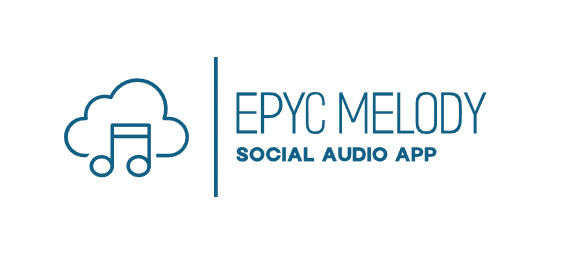

# 01 : Modèle n°0 - popularité & scores de sentiments

Notre première approche et compréhension du projet fut de définir un modèle de prédiction d’appréciation et de popularité des chansons en fonction de divers paramètres comme les caractéristiques musicales ou encore la localisation géographique des utilisateurs.

Cette approche ne nous permettra pas d'aboutir à un modèle correct, et sera abandonnée au profit d'un système de recommandations (modèles 1 & 2).

In [1]:
# librairies
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import timedelta
begin_time = time.time()

In [2]:
df_global = pd.read_csv('df_global.csv')

In [3]:
df_global.head()

,index,user_id,track_id,artist_id,created_at,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,region,hashtag,sent_score
0,0,81496937,cd52b3e5b51da29e5893dba82a418a4b,b2980c722a1ace7a30303718ce5491d8,2014-01-01 05:54:21,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,America,goth,NaN
1,1,81496937,cd52b3e5b51da29e5893dba82a418a4b,b2980c722a1ace7a30303718ce5491d8,2014-01-01 05:54:21,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,America,deathrock,0.190625
2,2,81496937,cd52b3e5b51da29e5893dba82a418a4b,b2980c722a1ace7a30303718ce5491d8,2014-01-01 05:54:21,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,America,postpunk,0.000000
3,3,2205686924,da3110a77b724072b08f231c9d6f7534,5cddcd0e314e2f2223ab21937d2c8778,2014-01-01 05:54:22,0.01770,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826,undefined,80s,NaN
4,4,2205686924,da3110a77b724072b08f231c9d6f7534,5cddcd0e314e2f2223ab21937d2c8778,2014-01-01 05:54:22,0.01770,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826,undefined,retro,NaN


In [4]:
df_global.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351534 entries, 0 to 6351533
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   index             6351534 non-null  int64  
 1   user_id           6351534 non-null  int64  
 2   track_id          6351534 non-null  object 
 3   artist_id         6351534 non-null  object 
 4   created_at        6351534 non-null  object 
 5   instrumentalness  6351534 non-null  float64
 6   liveness          6351534 non-null  float64
 7   speechiness       6351534 non-null  float64
 8   danceability      6351534 non-null  float64
 9   valence           6351534 non-null  float64
 10  loudness          6351534 non-null  float64
 11  tempo             6351534 non-null  float64
 12  acousticness      6351534 non-null  float64
 13  energy            6351534 non-null  float64
 14  region            6351534 non-null  object 
 15  hashtag           6351531 non-null  object 
 16  

***
## Distribution des scores de popularité

22 variables, 11 614 671 entrées.

Ce jeu de données apporte les caractéristiques musicales de chaque morceau de musique référencé par un ou des utilisateurs.<br>
Ces caractéristiques musicales sont sous forme numérique : « instrumentalness », « liveness », …


<u><b>Aperçu des données</b></u>

Distribution des 3 différentes variables de popularité :

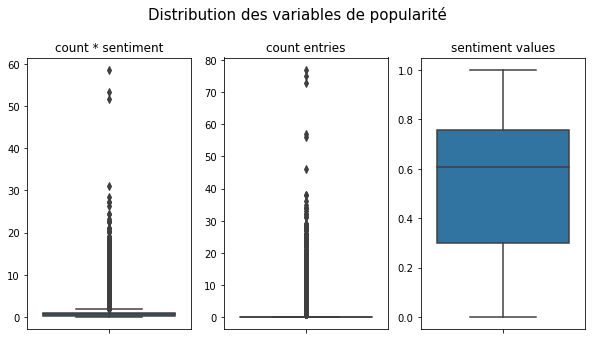

In [5]:
df_usr_trck = df_global[['user_id', 'track_id', 'hashtag', 'sent_score']].groupby(['user_id','track_id']).mean().reset_index()

df_tracks = df_global[['track_id', 'hashtag', 'sent_score']].groupby(['track_id']).mean().reset_index()

df_tracks['countentries'] = df_usr_trck.groupby(['track_id']).count().reset_index()['sent_score']

df_tracks['popularity'] = df_tracks['countentries']*df_tracks['sent_score']

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=False)

## popularity score for combined count*sentiment
sns.boxplot(y=df_tracks['popularity'],  orient='v', ax=axes[0]);
axes[0].set_title('count * sentiment');
axes[0].set_ylabel('');

## popularity score for count only
sns.boxplot(y=df_tracks['countentries'],  orient='v', ax=axes[1]);
axes[1].set_title('count entries');
axes[1].set_ylabel('');

## popularity score for sentiment only
sns.boxplot(y=df_tracks['sent_score'],  orient='v', ax=axes[2]);
axes[2].set_title('sentiment values');
axes[2].set_ylabel('');

plt.gcf().text(0.5, 1, 'Distribution des variables de popularité', fontsize=15, horizontalalignment='center', verticalalignment='center') ;


Popularité d'un morceau :

In [6]:
# ne conserver qu'un morceau par utilisateur
df_1user_1track = df_global.drop_duplicates(subset=['user_id', 'track_id'], keep='last')

# supprimer les entrées sans score de sentiment
df_1user_1track = df_1user_1track.dropna(subset=['sent_score'])

# popularité d'un morceau (nombre d'écoute par différents utilisateurs)
pop = pd.DataFrame(df_1user_1track[['track_id','user_id']].groupby(['track_id']).size().reset_index(name='popularite')).sort_values(by='popularite', ascending=False)
pop

,track_id,popularite
8068,5758909ef03fc3a2efaa57408ad43f22,50
5645,3d02f9fcad37e6bb227682761039498c,49
9137,6395d4b468d18225bd8617a1029112c8,47
19800,d6b1124fdd64c4b1afa59f967397111d,45
6478,462b1fc2bc97a2c8de40946cba29fd21,32
...,...,...
9247,64bb3c10a78fe7be6cbe7ce42afcfb42,1
9246,64ba29072b2c0d5fcbe02e2dce3b1c75,1
9245,64b618dc96440e06aa036be441863658,1
9244,64b30f6ac1acecb7cef9dc890e1c3ea7,1


In [7]:
# distribution des scores de popularité (nb d'utilisateurs ayant écouté le morceau)
pd.DataFrame(pop['popularite'].value_counts()).sort_index().rename(columns={'popularite': 'nb_track'}).rename_axis('popularite (nb_user)').T


popularite (nb_user),1,2,3,4,5,6,7,8,9,10,...,23,24,25,29,30,32,45,47,49,50
nb_track,16646,3607,1397,707,407,258,179,100,57,42,...,2,1,1,1,1,2,1,1,1,1


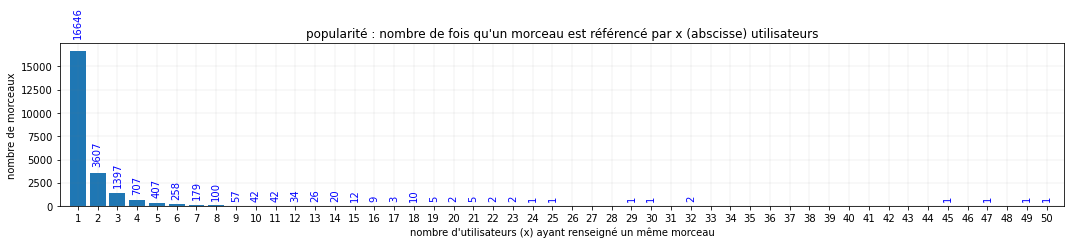

In [8]:
# affichage graphique de la distribution des scores de popularité
labels, counts = np.unique(pop['popularite'], return_counts=True)

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(3)

arr = plt.bar(labels, counts, align='center')

# affichage du nb de référencement (valeur count de l'histogramme)
for rect in arr:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height+500,
            '%d' % int(height),
            ha='center', va='bottom', rotation=90, color="blue")

ax.set_xticks(np.arange(0, 51, step=1));
ax.margins(x=0.01)
ax.grid(color='gray', linestyle='-', linewidth=.1)
ax.set_title('popularité : nombre de fois qu\'un morceau est référencé par x (abscisse) utilisateurs')
ax.set_xlabel('nombre d\'utilisateurs (x) ayant renseigné un même morceau')
ax.set_ylabel('nombre de morceaux')

plt.show();

Pour les plus populaires : 1 morceau est référencé par 50 utilisateurs, un autre par 49, …, 2 par 32 utilisateurs, 10 par 19 utilisateurs, etc…<br/>
Pour les moins populaires : 16656 morceaux différents renseignés par un seul utilisateur, 3607 renseignés par 2 utilisateurs, … 100 renseignés par 8 utilisateurs, etc

***
## Popularité & score de sentiments

Recherche d'un lien entre la popularité d'un morceau et la valeur / score de sentiment (sent_score).

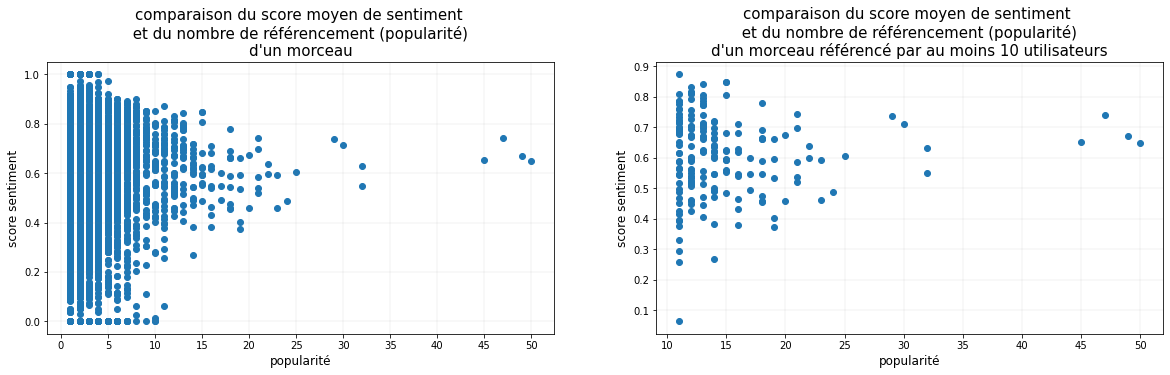

In [9]:
# pivot table sur track > moyenne des scores & nombre d'utilisateurs ayant référencé le track 
pop_sent = pd.pivot_table(df_1user_1track[['track_id', 'user_id', 'sent_score']],
                     values=['user_id', 'sent_score'],
                     index=['track_id'],
                     aggfunc={'user_id': lambda x: len(x.unique()),
                              'sent_score': np.mean})
pop_sent = pop_sent.sort_values(by=['user_id', 'sent_score'], ascending=False)

# beaucoup de valeurs à 1
# => sélections des morceaux ayant > min_user utilisateurs 
min_popularite=15
# pop_sent[pop_sent['user_id']>min_popularite].head()


plt.figure(figsize=(20,5))

# graphique score moyen de sentiment et popularité

plt.subplot(121)

plt.scatter(x=pop_sent['user_id'],y=pop_sent['sent_score'])

plt.title(f'comparaison du score moyen de sentiment \n et du nombre de référencement (popularité) \nd\'un morceau', fontsize=15)
plt.xlabel('popularité', fontsize=12)
plt.ylabel('score sentiment', fontsize=12)

plt.xticks(np.arange(0, 55, step=5))
plt.grid(color='gray', linestyle='-', linewidth=.1);


# graphique score moyen de sentiment et popularité
# pour un morceau référencé au moins 10x

plt.subplot(122)

min_popularite=10
                                    
plt.scatter(x = pop_sent[pop_sent['user_id']>min_popularite][['user_id']],
            y = pop_sent[pop_sent['user_id']>min_popularite][['sent_score']])

plt.title(f'comparaison du score moyen de sentiment \n et du nombre de référencement (popularité) \nd\'un morceau référencé par au moins {min_popularite} utilisateurs', fontsize=15)
plt.xlabel('popularité', fontsize=12)
plt.ylabel('score sentiment', fontsize=12)

plt.xticks(np.arange(10, 55, step=5))
plt.grid(color='gray', linestyle='-', linewidth=.1);


Ce n’est guère parlant pour les morceaux peu populaires, le score de sentiment varie grandement.

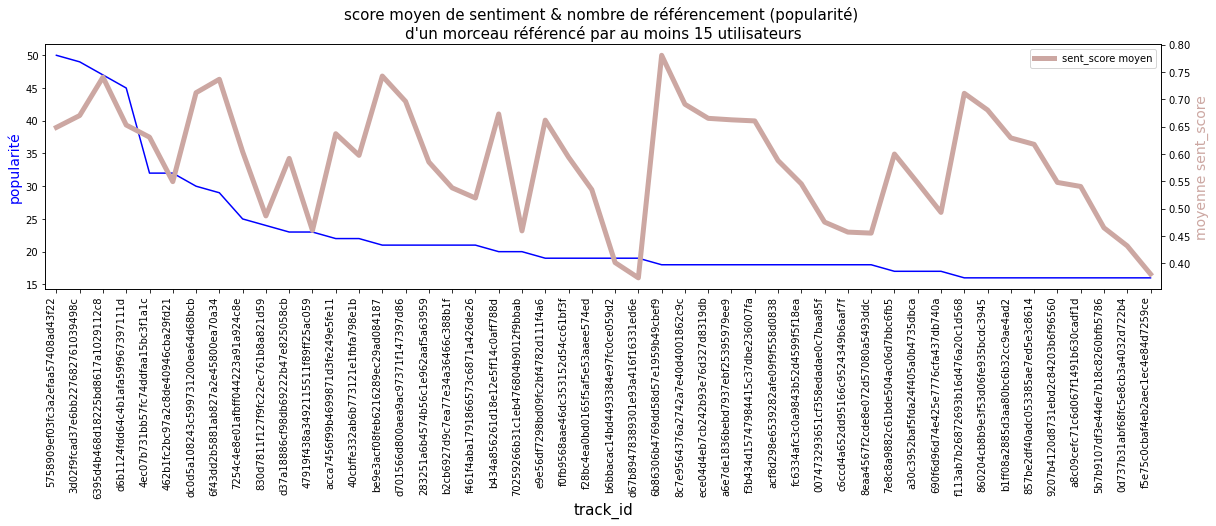

In [10]:
# graphique score moyen de sentiment et popularité
min_popularite=15

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.autofmt_xdate(rotation=90)

ax2 = ax1.twinx()
ax1.margins(x=0.01)
ax1.plot(pop_sent[pop_sent['user_id']>min_popularite][['user_id']], c='blue', label="popularité")
ax2.plot(pop_sent[pop_sent['user_id']>min_popularite][['sent_score']], c="#CCA7A2", linewidth=5, label="sent_score moyen")

ax1.set_xlabel('track_id', fontsize=15)
ax1.set_ylabel('popularité', color='blue', fontsize=14)
ax2.set_ylabel('moyenne sent_score', color='#CCA7A2', fontsize=14)

plt.title(f'score moyen de sentiment & nombre de référencement (popularité) \nd\'un morceau référencé par au moins {min_popularite} utilisateurs', fontsize=15)

plt.legend();


Idem, il ne semble pas y avoir de relation entre le score moyen de sentiment d’un morceau et sa popularité.

<u>Distribution des scores de sentiment en fonction de diverses popularités :</u>

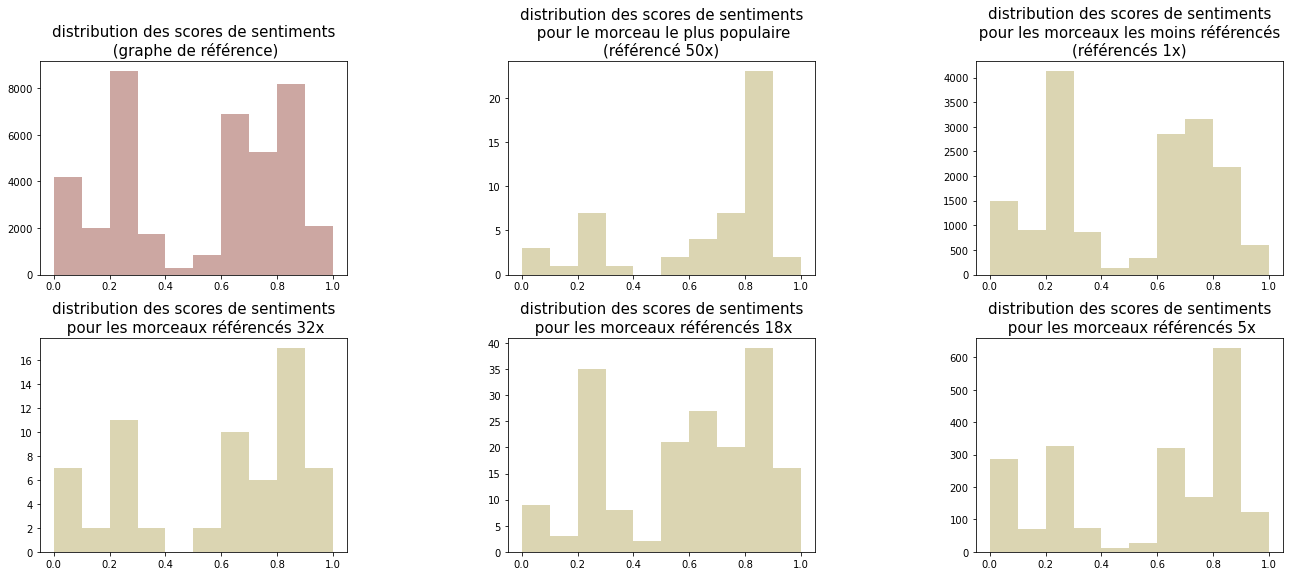

In [11]:
# plt.figure(figsize=(20,10),pad=3.0)
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout()
fig.set_figwidth(20)
fig.set_figheight(8)

# distribution des scores de sentiment - référence
axes[0,0].hist(df_1user_1track['sent_score'], color='#CCA7A2');
axes[0,0].set_title(f'distribution des scores de sentiments\n (graphe de référence)', fontsize=15);

# distribution des scores de sentiment pour le morceau le plus référencé (+ forte popularité)
most_popular_track_id = pop[(pop['popularite'] == pop['popularite'].max())]['track_id'].values[0]
axes[0,1].hist(df_1user_1track[df_1user_1track['track_id'] == most_popular_track_id]['sent_score'], color='#DBD5B2');
axes[0,1].set_title(f'distribution des scores de sentiments\n pour le morceau le plus populaire\n(référencé 50x)', fontsize=15);

# distribution des scores de sentiment pour les morceaux les moins populaires (référencés 1x)
popularity_1user_per_track_id = pop[(pop['popularite'] == 1)]['track_id']
axes[0,2].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_1user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[0,2].set_title(f'distribution des scores de sentiments\n pour les morceaux les moins référencés \n(référencés 1x)', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 32x
popularity_32user_per_track_id = pop[(pop['popularite'] == 32)]['track_id']
axes[1,0].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_32user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,0].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 32x', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 18x
popularity_18user_per_track_id = pop[(pop['popularite'] == 18)]['track_id']
axes[1,1].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_18user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,1].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 18x', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 5x
popularity_5user_per_track_id = pop[(pop['popularite'] == 5)]['track_id']
axes[1,2].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_5user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,2].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 5x', fontsize=15);


Ces distributions ne permettent pas non plus d’identifier un lien entre score de sentiment et popularité d’un morceau.

<u>En conclusion :</u><br>
Il semblerait que la popularité d’un morceau n’ait pas d’incidence sur le score de sentiment, et inversement.<br>
Les deux variables sont peut-être complémentaires.

***
## Fin

In [12]:
print("\ntps d'éxécution total du notebook: ",timedelta(seconds=round((time.time() - begin_time),0)))


tps d'éxécution total du notebook:  0:01:22
